In [323]:
import ROOT
from larlite import *
from ROOT import PandoraNuTrack
from ROOT import AnalyseEvents
import matplotlib.colors as colors
import sys; sys.path.insert(0, '../');
# %matplotlib inline
%matplotlib notebook
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
sys.path.insert(0, '/Users/erezcohen/larlite/UserDev/mySoftware/MySoftwarePackage/mac/')
from plot_tools import *
from matplotlib.ticker import NullFormatter

In [319]:
file=ROOT.TFile("/Users/erezcohen/Desktop/uBoone/CCQEanalysis/EventsFiles/EventsFile.root")
tree=file.Get("EventsAnalyzer/eventsTree")
ana=AnalyseEvents(tree)

In [4]:
def gen_tracks_and_hits( ana=None, entry=0 , debug=0 ):
    if ana is None: 
        print "ana is None! returning..."
        return
    ana.GetEntry( entry )
    tracks = ana.GetTracks()
    hits = ana.GetHits()
    if debug:
        print '%d track, %d hits'%(int(tracks.size()),int(hits.size()))
    return hits,tracks

In [313]:
#---------------------------------------------------------------------------------------------
def get_t_start_end(t,plane): # t is a track
    if plane==0:    
        t_start_wire,t_start_time = t.start_wire_u, t.start_time_u                
        t_end_wire,t_end_time = t.end_wire_u, t.end_time_u
    elif plane==1:                
        t_start_wire,t_start_time = t.start_wire_v, t.start_time_v                                    
        t_end_wire,t_end_time = t.end_wire_v, t.end_time_v                
    elif plane==2:                            
        t_start_wire,t_start_time = t.start_wire_y, t.start_time_y                                    
        t_end_wire,t_end_time = t.end_wire_y, t.end_time_y            
    return t_start_wire , t_start_time , t_end_wire , t_end_time
#---------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------
def plot_tracks(hits,plane,ax=None,cmap='hot_r',color='',do_add_numbers=False, do_add_text=False):
    for t in tracks:
        color, label,_ = set_color_label_cmap(t)
        #         print t.MCpdgCode
        t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(t,plane)
        plt.plot([t_start_wire,t_end_wire],[t_start_time,t_end_time],color=color)
        if do_add_text: plt.text(t_start_wire + 0.3*(t_end_wire-t_start_wire),t_start_time,label,color=color,fontsize=20)
#---------------------------------------------------------------------------------------------


# ------------------------------------------------
def set_color_label_cmap(t,do_add_PfromRange=False):
    
    pdg = t.MCpdgCode
    t_length = t.length
    cmap = 'Purples'
    
    if pdg==-13:
        color = 'black'
        label = '$\\mu^+$'
        cmap = 'Greys'
    elif pdg==13:
        color = 'black'
        label = '$\\mu^-$'
        cmap = 'Greys'   
    elif pdg==-11:
        color = 'red'
        label = '$e^+$'
        cmap = 'Reds'   
    elif pdg==11:
        color = 'red'
        label = '$e^-$'
    elif pdg==2212:
        color = 'blue'
        label = '$p$'
        cmap = 'Blues'   
    elif pdg==2112:
        color = 'salmon'
        label = '$n$'
        cmap = 'Oranges'   

    elif pdg==-211:
        color = 'teal'
        label = '$\\pi^-$'
        cmap = 'Greens'   

    elif pdg==211:
        color = 'teal'
        label = '$\\pi^+$'
        cmap = 'Greens'   

    elif pdg==111:
        color = 'teal'
        label = '$\\pi^0$'
        cmap = 'Greens'   

    elif pdg==22:
        color = 'cyan'
        label = '$\\gamma$'
        cmap = 'cool'   

    else:
        color = 'purple'
        label = '%d'%pdg
        cmap = 'Purples'   

        
    if do_add_PfromRange:
        Ptruth = t.truth_P
        if np.abs(pdg)==13:
            PfromRange = 0.001*muon_momontum_from_range(t_length)
    return color , label , cmap
# ------------------------------------------------

In [314]:
def draw_event_display( hits=None, tracks=None , do_add_legend=False, planes=[0,1,2], do_add_hit_trkKey=False ,
                       xlim=None , ylim=None ):
    fig=plt.figure(figsize=(28,8))
    for plane in planes:
        ax=fig.add_subplot(1,3,plane+1)
        plot_hits(hits , plane=plane , ax=ax , cmap='hot_r',do_add_hit_trkKey=do_add_hit_trkKey, tracks=tracks)
        if do_add_legend and plane==2: ax.add_legend(bbox_to_anchor(1,1.05),loc=2,fontsize=20)
        if plane>0: ax.yaxis.set_major_formatter( NullFormatter() )
        if xlim is not None: ax.set_xlim(xlim[plane])
        if ylim is not None: ax.set_ylim(ylim)            
        set_axes(ax,'wire','time tick' if plane==0 else '',xticks=np.linspace(np.min(ax.get_xlim()),np.max(ax.get_xlim()),5))
        plot_tracks(tracks , plane=plane , ax=ax , do_add_text=False )

In [315]:
def find_hit_color(hit_trkKey=None,tracks=None):
    if tracks is None: return 'purple'
    for t in tracks:
        if t.track_id == hit_trkKey:
            color,_ = set_color_label(t)
            return color
    return 'white'

In [320]:
#---------------------------------------------------------------------------------------------
def plot_hits(hits,plane,ax=None,cmap='hot_r',do_add_hit_trkKey=False,do_add_numbers=False,tracks=None):
    hit_wire, hit_time, hit_charge , hit_number , hit_trkKey, hit_color = [] , [] , [] , [] , [], []
    # hits in this plane
    hits_df=pd.DataFrame({})
    associated_hits=dict()
    for t in tracks:
        associated_hits[t.track_id] = pd.DataFrame()
    non_associated_hits = pd.DataFrame()
    for i_hit,hit in enumerate(hits):
        if hit.hit_plane==plane:# and hit_in_box(hit,box=box):
            hit_number.append(i_hit)
            hit_wire.append(hit.hit_wire)
            hit_time.append(hit.hit_peakT)
            hit_charge.append(hit.hit_charge)
            hit_trkKey.append(hit.hit_trkKey)
            hit_color.append( find_hit_color(hit.hit_trkKey,tracks) )
            hit_df = pd.DataFrame({'plane':plane,
                                   'wire':hit.hit_wire,                                   
                                   'time':hit.hit_peakT,                                   
                                   'charge':hit.hit_charge}                                   
                                  ,index=[i_hit])

            if (hit.hit_trkKey!=-1): # change this to -1! -9999 is the default PDG code of an unknown particle
                associated_hits[hit.hit_trkKey]=associated_hits[hit.hit_trkKey].append( hit_df ,ignore_index=True)
            else:
                non_associated_hits = non_associated_hits.append( hit_df ,ignore_index=True)

    vmin=np.min(non_associated_hits['charge'])
    vmax=np.max(non_associated_hits['charge']) 
    ax.scatter(non_associated_hits['wire'],non_associated_hits['time'],c=non_associated_hits['charge'],vmin=vmin, vmax=vmax,s=20, cmap='hot_r' )
    for t in tracks:
        color,label,cmap = set_color_label_cmap( t )
        if associated_hits[t.track_id].empty is False:
            vmin=np.min(associated_hits[t.track_id]['charge'])
            vmax=np.max(associated_hits[t.track_id]['charge'])
#             print "vmin,vmax:",vmin,vmax
            ax.scatter(associated_hits[t.track_id]['wire'],associated_hits[t.track_id]['time'],c=associated_hits[t.track_id]['charge'],s=20, cmap=cmap , norm=colors.LogNorm(vmin, vmax))
#---------------------------------------------------------------------------------------------

In [321]:
hits , tracks = gen_tracks_and_hits( ana, entry=25 , debug=True )

7 track, 5327 hits


<IPython.core.display.Javascript object>


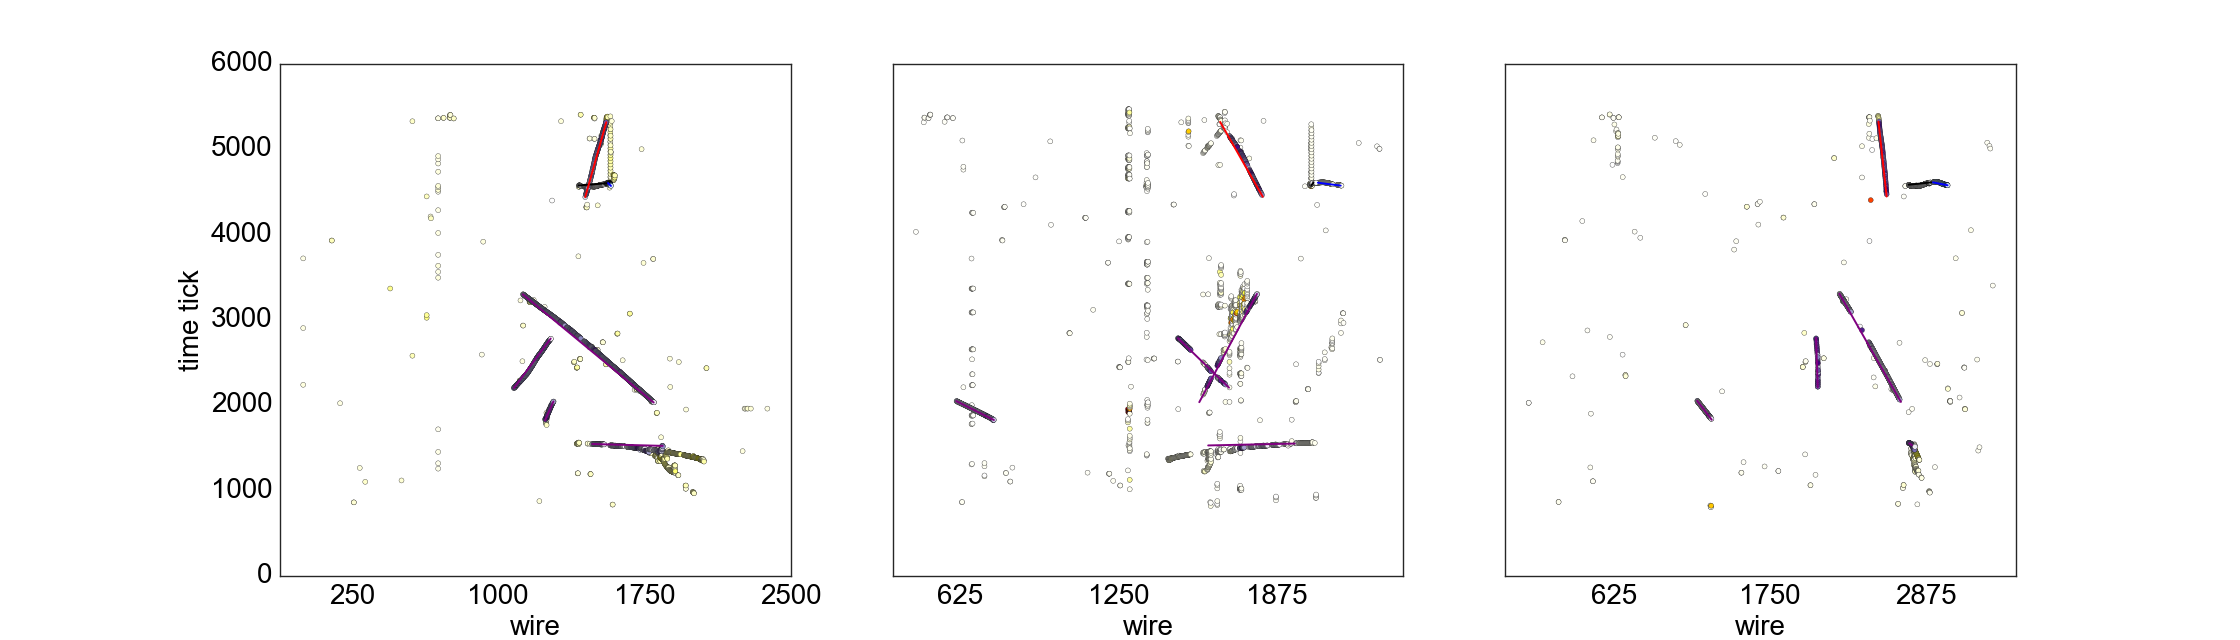

In [324]:
draw_event_display( hits , tracks , planes=[0,1,2]
#                    , xlim = [[1300,1750],[1800,2100],[2700,3000]]
#                    , ylim = [1300,4000]
                  )